<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4

## Help Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.



---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import (LinearRegression, LogisticRegression, 
                                  Lasso, Ridge,
                                  SGDRegressor, SGDClassifier)
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import scipy.stats as stats
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

In [13]:
business = pd.read_csv('/home/llevin/Desktop/DSI-SF-2-llevin16/Projects/Project 5/Data/yelp_arizona_data/businesses_small_parsed.csv')
checkins = pd.read_csv('/home/llevin/Desktop/DSI-SF-2-llevin16/Projects/Project 5/Data/yelp_arizona_data/checkins_small_parsed.csv')
reviews = pd.read_csv('/home/llevin/Desktop/DSI-SF-2-llevin16/Projects/Project 5/Data/yelp_arizona_data/reviews_small_nlp_parsed.csv')
tips = pd.read_csv('/home/llevin/Desktop/DSI-SF-2-llevin16/Projects/Project 5/Data/yelp_arizona_data/tips_small_nlp_parsed.csv')
users = pd.read_csv('/home/llevin/Desktop/DSI-SF-2-llevin16/Projects/Project 5/Data/yelp_arizona_data/users_small_parsed.csv')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

DATA CLEANING PHASE

In [14]:
b_parsed = business.loc[:,['business_id','city','categories','variable','value']]

In [15]:
#Pivot into wide format
b_parsed['variable'].unique()
b_parsed = b_parsed[b_parsed['variable'].isin(['attributes.Dietary Restrictions.vegan','attributes.Outdoor Seating',
                                    'attributes.Parking.lot','attributes.Music.live',
                                    'attributes.Accepts Credit Cards','attributes.Wi-Fi',
                                    'attributes.Wheelchair Accessible','attributes.Smoking'])]
pivot_b = pd.pivot_table(b_parsed,index=['business_id','city','categories'],columns='variable',values='value',
                        fill_value=False,aggfunc=np.min).reset_index()

In [16]:
#Clean column names
pivot_b['target'] = pivot_b['city'].map(lambda x: 1 if x == 'Las Vegas' else 0)
def column_rename(df):
    columns = []
    for col in df.columns:
        if 'attributes' in col:
            col = col.replace('attributes.','')
            columns.append(col)
        else:
            columns.append(col)
    return columns

pivot_b.columns = column_rename(pivot_b)

In [17]:
for col in pivot_b.columns:
    print pivot_b[col].value_counts()

RkSU74wqRh0GdMYObcxTxQ    1
OAyA2ogCSAn8UHcI9UuQ_w    1
Xk3inJcuBGLhavUcdlINZA    1
nHQ11YXvzL8awYoF-uD16A    1
FBr0VLYwiuy-LhSPQIKsAA    1
ueQZS9kPFfZL3m02B-PDcA    1
eMTUYYDgYUyY_1isy5SK7Q    1
kyNHcuvg7Rl1gzrPFvZI6Q    1
W6Cow2y5Im9GjmGYQf2VTw    1
M_GnuvRXvWBl3YNxH-GYFg    1
0dJZy_0M_GwkLvpZ8r6bpQ    1
oaakO-X7uOXNxqsxjDSKfg    1
dbObnYBNgKR-ADGhLfLm_A    1
a-AZsbPwYcM_7SQgHTHktg    1
ijd7e9Oydq3C9raOjZbWcA    1
kIFpLI4idnr3JmAhII8mkA    1
inUZjzhym_elppg9fkWSwA    1
jCaQauhwHFyjOSlCutqUnA    1
6IRoWd6N__OVMNQfvu1Ccw    1
riTkPznlAPl86dazAjPO3A    1
ou4AVoe44B7MrltR4hUD6g    1
z0rAS1Epu8VtVunP_QxbmQ    1
DnsBFSBAlIVsQ7u_ZUWdCQ    1
Yc3YFHUWnDfLF424uOvOTw    1
OF7wkQXbhPLsM_otADEmeA    1
PBej5DE0QOF-XW0pK1cL5w    1
m4smA_nzGkRgqcspfyzSaA    1
GVUtuBmDdvXxXtjrvHHJnQ    1
EUQeiBgInhw49zFpDscwOg    1
GDOk9k-k-f5oPxmn1cd9ug    1
                         ..
4TWNKtG_S2kMdwNbERK45g    1
wKktSDVL_IPvwbW6SycdgA    1
0xDeTJYgo5X_ZsuI3BJ01g    1
5GKbGn9-fAgQ0njSh3OJ8A    1
B65lkdJejJZadZ5kCwV3

In [18]:
#Convert attributes to boolean
pivot_b = pivot_b[['business_id','city','categories','Accepts Credit Cards','Music.live','Outdoor Seating',
       'Parking.lot','Smoking','Wheelchair Accessible','Wi-Fi','target']]
pivot_b['Accepts Credit Cards'] = pivot_b['Accepts Credit Cards'].map(lambda x: True if x == 'True' else False)
pivot_b['Music.live'] = pivot_b['Music.live'].map(lambda x: True if x == 'True' else False)
pivot_b['Outdoor Seating'] = pivot_b['Outdoor Seating'].map(lambda x: True if x == 'True' else False)
pivot_b['Parking.lot'] = pivot_b['Parking.lot'].map(lambda x: True if x == 'True' else False)
pivot_b['Wheelchair Accessible'] = pivot_b['Wheelchair Accessible'].map(lambda x: True if x == 'True' else False)
pivot_b['Smoking'] = pivot_b['Smoking'].map(lambda x: False if (x == 'no')|(x==False) else True)
pivot_b['Wi-Fi'] = pivot_b['Wi-Fi'].map(lambda x: False if (x == 'no')|(x==False) else True)

In [19]:
pivot_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3945 entries, 0 to 3944
Data columns (total 11 columns):
business_id              3945 non-null object
city                     3945 non-null object
categories               3945 non-null object
Accepts Credit Cards     3945 non-null bool
Music.live               3945 non-null bool
Outdoor Seating          3945 non-null bool
Parking.lot              3945 non-null bool
Smoking                  3945 non-null bool
Wheelchair Accessible    3945 non-null bool
Wi-Fi                    3945 non-null bool
target                   3945 non-null int64
dtypes: bool(7), int64(1), object(3)
memory usage: 150.3+ KB


In [20]:
reviews.head(3).T

,0,1,2
user_id,o_LCYay4uo5N4eq3U5pbrQ,sEWeeq41k4ohBz4jS_iGRw,1AqEqmmVHgYCuzcMrF4h2g
review_id,biEOCicjWlibF26pNLvhcw,tOhOHUAS7XJch7a_HW5Csw,2aGafu-x7onydGoDgDfeQQ
votes.cool,0,3,0
business_id,EmzaQR5hQlF0WIl24NxAZA,EmzaQR5hQlF0WIl24NxAZA,EmzaQR5hQlF0WIl24NxAZA
votes.funny,0,12,2
stars,3,2,2
date,2007-09-14,2008-04-21,2009-11-16
votes.useful,1,3,0
10 minutes,0,0,0
15 minutes,0,0,0


In [21]:
#Group by business id
reviews['Reviews']=1
cols = [col for col in reviews.columns if col not in ['user_id','review_id','date']]
reviews = reviews[cols]
grouped_r = reviews.groupby('business_id').sum().reset_index()

In [22]:
#Merge business and reviews datasets
business_vf = grouped_r.merge(pivot_b,how='inner',left_on='business_id',right_on='business_id')

In [23]:
business_vf.head(3).T

,0,1,2
business_id,--jFTZmywe7StuZ2hEjxyA,-0HGqwlfw3I8nkJyMHxAsQ,-0VK5Z1BfUHUYq4PoBYNLw
votes.cool,11,0,2
votes.funny,7,3,2
stars,17,27,15
votes.useful,13,1,1
10 minutes,0,0,0
15 minutes,0,0,0
20 minutes,0,0,0
30 minutes,0,0,0
bar food,0,0,0


In [13]:
#Pivot checkins into wide format
pivot_c = pd.pivot_table(checkins,index=['business_id'],columns='variable',values='value',
                         fill_value = 0, aggfunc=np.sum).reset_index()

In [14]:
#Clean column names
def column_rename2(df):
    columns = []
    for col in df.columns:
        if 'checkin' in col:
            col = col.replace('checkin_info.','')
            columns.append(col)
        else:
            columns.append(col)
    return columns

pivot_c.columns = column_rename2(pivot_c)

In [15]:
#Merge checkins into final dataset
business_vf = business_vf.merge(pivot_c,how='inner',left_on='business_id',right_on='business_id')

In [16]:
business_vf.describe()

,votes.cool,votes.funny,stars,votes.useful,10 minutes,15 minutes,20 minutes,30 minutes,bar food,beer selection,...,8-4,8-5,8-6,9-0,9-1,9-2,9-3,9-4,9-5,9-6
count,3707.000000,3707.000000,3707.000000,3707.000000,3707.000000,3707.000000,3707.000000,3707.000000,3707.000000,3707.000000,...,3707.000000,3707.000000,3707.000000,3707.000000,3707.000000,3707.000000,3707.000000,3707.000000,3707.000000,3707.000000
mean,56.048827,47.316159,319.840302,90.492582,1.212841,1.113299,1.058268,0.852711,0.689237,0.848125,...,1.529539,2.079579,1.910440,1.610197,1.387645,1.387375,1.506339,1.828433,3.046938,3.079309
std,147.211797,130.477230,834.313905,224.071555,3.707938,3.909196,3.773520,3.753307,2.703059,5.653741,...,18.573678,17.393695,17.100054,17.083457,13.519209,12.793766,15.150625,16.921080,17.779029,19.243495
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,27.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,11.000000,77.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,44.000000,37.000000,259.000000,77.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2646.000000,3008.000000,20899.000000,3967.000000,83.000000,101.000000,110.000000,121.000000,50.000000,137.000000,...,812.000000,688.000000,687.000000,722.000000,547.000000,541.000000,637.000000,693.000000,662.000000,747.000000


REGRESSION PHASE

In [17]:
#Set up target and predictors and normalize
y = business_vf['target']
X = business_vf[[col for col in business_vf.columns if col not in ['target','city','categories','business_id',
                                                                  'las vegas','time vegas']]]

scale = StandardScaler()
Xn = scale.fit_transform(X)

print Xn.shape,y.shape

(3707, 278) (3707,)


In [18]:
# Setup our GridSearch Parmaters
search_parameters = {
    'penalty':  ['l1','l2'],
    'solver':  ['liblinear']
}

# Intialize a blank model object
log = LogisticRegression()

# Initialize gridsearch
grid = GridSearchCV(log, search_parameters, cv=5, verbose=1)
log_best = grid.fit(Xn,y).best_estimator_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.6s finished


In [22]:
# Setup our GridSearch Parmaters
search_parameters = {
    'n_neighbors':  range(1,101), 
    'weights':      ['uniform', 'distance']
}

# Intialize a blank model object
knn = KNeighborsClassifier()

# Initialize gridsearch
grid = GridSearchCV(knn, search_parameters, cv=5,verbose=1)
knn_best = grid.fit(Xn,y).best_estimator_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   58.0s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  4.0min
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  9.1min
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed: 16.4min
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 20.6min finished


In [23]:
#Manual cross validation and results printing
cv_indices = StratifiedKFold(y, n_folds=5)

knn_scores = []
log_scores = []

for train,test in cv_indices:
    x_train = Xn[train,:]
    x_test = Xn[test,:]
    y_train = y[train]
    y_test = y[test]
    
    knn_best.fit(x_train,y_train)
    log_best.fit(x_train,y_train)
    
    knn_scores.append(knn_best.score(x_test,y_test))
    log_scores.append(log_best.score(x_test,y_test))

print knn_scores
print log_scores
print 'KNN Score: ',np.mean(knn_scores)
print 'Log Score: ',np.mean(log_scores)
print 'Baseline: ',np.mean(y)

[0.67698519515477795, 0.68421052631578949, 0.73279352226720651, 0.67341430499325239, 0.708502024291498]
[0.73351278600269176, 0.76248313090418351, 0.77327935222672062, 0.73819163292847501, 0.78002699055330638]
KNN Score:  0.695181114605
Log Score:  0.757498778523
Baseline:  0.631507957917


In [24]:
#Sort most important variables
importance = pd.DataFrame({'Coef':log_best.coef_[0],'Abs_Coef':np.abs(log_best.coef_[0]),'Variable':X.columns})
importance.sort_values('Abs_Coef',ascending=False,inplace=True)
importance[0:10]

,Abs_Coef,Coef,Variable
244,1.827090,-1.827090,5-1
145,1.743134,1.743134,13-0
263,1.649451,-1.649451,7-6
270,1.615477,-1.615477,8-6
272,1.604111,1.604111,9-1
147,1.557990,1.557990,13-2
132,1.465144,-1.465144,11-1
12,1.463623,1.463623,bottle service
234,1.426940,1.426940,3-5
1,1.424897,-1.424897,votes.funny


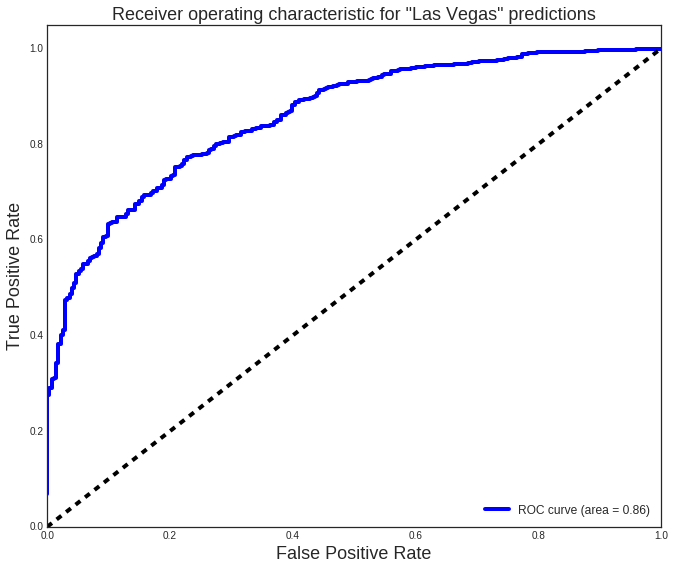

In [28]:
log_probs = log_best.predict_proba(x_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

FPR[1], TPR[1], _ = roc_curve(y_test, log_probs[:, 1])
ROC_AUC[1] = auc(FPR[1], TPR[1])

# [insert explanation of this section -- what is being plotted?  Which elements are data driven?  Which elements are purely visual?]
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for "Las Vegas" predictions', fontsize=18)
plt.legend(loc="lower right")
plt.show()

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

group by business
merge
split into food and service datasets
run knn and logistic on both
print out estimators/coefficiants? sort values?

DATA CLEANING PHASE

In [24]:
#This is the function I created to classify the reviews and tips but it took too long so I used Kiefer's version
#below.
# def yelp_class(row, class1=food, class2=service):
#     if np.sum(row[class1]) > np.sum(row[class2]):
#         row['Class'] = 'food'
#     elif np.sum(row[class1]) < np.sum(row[class2]):
#         row['Class'] = 'service'
#     else:
#         row['Class'] = 'other'
#     return row

#Specify which columns refer to food and service based reviews          
food = ['bar food','beer selection','bloody mary','chicken waffles','eggs benedict','fast food',
       'fish chips','food amazing','food came','food delicious','food good','food great','food just',
       'food service','french fries','french toast','fried chicken','good food','great food',
       'hash browns','ice cream','mac cheese','mashed potatoes','medium rare','onion rings',
       'potato fries','quality food','red velvet','sweet potato']
service = ['bottle service','customer service','friendly staff','good service','great service',
          'service excellent','service food','service friendly','service good','service great',
          'staff friendly','super friendly','wait staff']

In [25]:
#Kiefer's code to create classification for reviews
foodcols = reviews[food]
servicecols = reviews[service]
foodsum = foodcols.sum(axis=1)
servesum = servicecols.sum(axis=1)
id_food = foodsum > servesum
id_serve = servesum > foodsum
user_id_col = pd.Series(np.tile('other', foodsum.shape[0]))
user_id_col[id_food] = 'food'
user_id_col[id_serve] = 'service'
reviews['Class']=user_id_col

In [26]:
#Same process for tips dataset
food = ['amazing food','animal style','awesome food','beef hash','beer selection','best breakfast','best burger',
        'best burgers','bloody mary','carne asada','cheese fries','chicken waffles','corned beef','delicious food',
        'eggs benedict','excellent food','fast food','fish chips','food amazing','food awesome','food drinks',
        'food good','food great','food service','french toast','fried chicken','gluten free','good food','great beer',
        'great breakfast','great burgers','great drinks','great food','grilled cheese','ice cream','love food',
        'mac cheese','nom nom','onion rings','potato fries','prime rib','red velvet','steak eggs','sweet potato',
        'velvet pancakes']
service = ['awesome service','bottle service','customer service','excellent service','fast service',
           'friendly service','friendly staff','good service','great prices','great service','great staff',
           'service food','service good','service great','slow service','staff friendly','staff great','worth wait']

In [27]:
foodcols = tips[food]
servicecols = tips[service]
foodsum = foodcols.sum(axis=1)
servesum = servicecols.sum(axis=1)
id_food = foodsum > servesum
id_serve = servesum > foodsum
user_id_col = pd.Series(np.tile('other', foodsum.shape[0]))
user_id_col[id_food] = 'food'
user_id_col[id_serve] = 'service'
tips['Class']=user_id_col

In [28]:
#Group both datasets by business Id and class
reviews_g = reviews.groupby(['business_id','Class']).sum().reset_index()
tips_g = tips.groupby(['business_id','Class']).sum().reset_index()

In [29]:
#Merge reviews and tips datasets and remove duplicate columns
reviews_vf = reviews_g.merge(tips_g,how='inner',left_on=['business_id','Class'],right_on=['business_id','Class'])
dedup = []
for col in reviews_vf.columns:
    if '_y'  not in col:
        dedup.append(col)
reviews_vf = reviews_vf[dedup]

In [30]:
#Create target variable calculation and split dataset into food and service data
reviews_vf['target']=(reviews_vf['stars']+reviews_vf['likes'])/reviews_vf['Reviews']
food_reviews = reviews_vf[reviews_vf['Class']=='food']
service_reviews = reviews_vf[reviews_vf['Class']=='service']

In [33]:
reviews_vf['target'].describe()

count    6491.000000
mean        3.550953
std         0.846593
min         1.000000
25%         3.001761
50%         3.666667
75%         4.138781
max         5.333333
Name: target, dtype: float64

In [38]:
path = '/home/llevin/Desktop/DSI-SF-2-llevin16/Week 6 Notes & Code/Datasets/service_reviews.csv'
service_reviews.to_csv(path)

REGRESSION PHASE

In [73]:
#Set up target and predictor variables and normalize
y = food_reviews['target'].reset_index(drop=True)
X = food_reviews[[col for col in food_reviews.columns if col not in\
                  ['target','Class','stars','likes','business_id','Reviews']]].reset_index(drop=True)

scale = StandardScaler()
Xn = scale.fit_transform(X)

print Xn.shape,y.shape

(1458, 159) (1458,)


In [74]:
# Setup our GridSearch Parameters
search_parameters = {
    'fit_intercept':  [True, False], 
    'normalize':      [False, True]
}

# Intialize a blank model object
lm = LinearRegression()

# Initialize gridsearch
estimator = GridSearchCV(lm, search_parameters, cv=5, verbose=1)
estimator = estimator.fit(Xn,y)
# Fit some data!
best_ln = estimator.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.3s finished


In [75]:
# Setup search parameters
search_parameters = {
    "alpha": np.linspace(0.0001, 1.0, 200)
}

lasso = Lasso()

estimator = GridSearchCV(lasso, search_parameters, cv=5, verbose=1)
estimator = estimator.fit(Xn,y)
# Fit some data!
best_lasso = estimator.best_estimator_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:    7.1s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    8.6s finished


In [76]:
# Setup search parameters
search_parameters = {
    "alpha": np.logspace(0,5,100)
}

ridge = Ridge()

estimator = GridSearchCV(ridge, search_parameters, cv=5, verbose=1)
estimator = estimator.fit(Xn,y)
# Fit some data!
best_ridge = estimator.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.5s finished


In [77]:
#Manual cross validation and results printing
cv_indices = StratifiedKFold(y, n_folds=5)

ln_scores = []
lasso_scores = []
ridge_scores = []

for train,test in cv_indices:
    x_train = Xn[train,:]
    x_test = Xn[test,:]
    y_train = y[train]
    y_test = y[test]
    
    best_ln.fit(x_train,y_train)
    best_lasso.fit(x_train,y_train)
    best_ridge.fit(x_train,y_train)
    
    ln_scores.append(best_ln.score(x_test,y_test))
    lasso_scores.append(best_lasso.score(x_test,y_test))
    ridge_scores.append(best_ridge.score(x_test,y_test))

print ln_scores
print lasso_scores
print ridge_scores
print 'Linear: ',np.mean(ln_scores)
print 'Lasso: ',np.mean(lasso_scores)
print 'Ridge: ',np.mean(ridge_scores)

baseline_X = np.ones(Xn.shape[0])[:,np.newaxis]
print 'Baseline: ',LinearRegression(fit_intercept=False).fit(baseline_X, y).score(baseline_X, y)

[-63.833222136025327, 0.091910321734028577, 0.03563393405383497, 0.055974649087712103, 0.085366159834990407]
[0.034731683508453126, 0.050491068064282829, 0.04137216514409281, 0.033640109190669398, 0.041559942008307482]
[0.09083874029696215, 0.068046875117741989, 0.054157138014309325, 0.048551688288430705, 0.056127307784257452]
Linear:  -12.7128674143
Lasso:  0.0403589935832
Ridge:  0.0635443499003
Baseline:  1.11022302463e-16


In [78]:
#Print out most important variables
importance_f = pd.DataFrame({'Coef':best_lasso.coef_,'Abs_Coef':np.abs(best_lasso.coef_),'Variable':X.columns})
importance_f.sort_values('Abs_Coef',ascending=False,inplace=True)
importance_f[0:10]

,Abs_Coef,Coef,Variable
28,0.109913,0.109913,food amazing_x
3,0.083031,-0.083031,10 minutes
33,0.066150,-0.066150,food just
47,0.062120,0.062120,great food_x
66,0.060241,0.060241,love place_x
5,0.039345,-0.039345,20 minutes
29,0.033180,-0.033180,food came
0,0.031844,0.031844,votes.cool
101,0.029596,0.029596,ve tried
53,0.028764,0.028764,highly recommend_x


In [79]:
#Same process for service data
y = service_reviews['target'].reset_index(drop=True)
X = service_reviews[[col for col in service_reviews.columns if col not in\
                  ['target','Class','stars','likes','business_id','Reviews']]].reset_index(drop=True)

scale = StandardScaler()
Xn = scale.fit_transform(X)

print Xn.shape,y.shape

(1362, 159) (1362,)


In [80]:
# Setup our GridSearch Parameters
search_parameters = {
    'fit_intercept':  [True, False], 
    'normalize':      [False, True]
}

# Intialize a blank model object
lm = LinearRegression()

# Initialize gridsearch
estimator = GridSearchCV(lm, search_parameters, cv=5, verbose=1)
estimator = estimator.fit(Xn,y)
# Fit some data!
best_ln = estimator.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.3s finished


In [81]:
# Setup search parameters
search_parameters = {
    "alpha": np.linspace(0.0001, 1.0, 200)
}

lasso = Lasso()

estimator = GridSearchCV(lasso, search_parameters, cv=5, verbose=1)
estimator = estimator.fit(Xn,y)
# Fit some data!
best_lasso = estimator.best_estimator_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    7.7s finished


In [82]:
# Setup search parameters
search_parameters = {
    "alpha": np.logspace(0,5,100)
}

ridge = Ridge()

estimator = GridSearchCV(ridge, search_parameters, cv=5, verbose=1)
estimator = estimator.fit(Xn,y)
# Fit some data!
best_ridge = estimator.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.3s finished


In [83]:
cv_indices = StratifiedKFold(y, n_folds=5,shuffle=True)

ln_scores = []
lasso_scores = []
ridge_scores = []

for train,test in cv_indices:
    x_train = Xn[train,:]
    x_test = Xn[test,:]
    y_train = y[train]
    y_test = y[test]
    
    best_ln.fit(x_train,y_train)
    best_lasso.fit(x_train,y_train)
    best_ridge.fit(x_train,y_train)
    
    ln_scores.append(best_ln.score(x_test,y_test))
    lasso_scores.append(best_lasso.score(x_test,y_test))
    ridge_scores.append(best_ridge.score(x_test,y_test))

print ln_scores
print lasso_scores
print ridge_scores
print 'Linear: ',np.mean(ln_scores)
print 'Lasso: ',np.mean(lasso_scores)
print 'Ridge: ',np.mean(ridge_scores)

baseline_X = np.ones(Xn.shape[0])[:,np.newaxis]
print 'Baseline: ',LinearRegression(fit_intercept=False).fit(baseline_X, y).score(baseline_X, y)

[-36.603037551265658, -36.42853029577919, -158382.21109529643, -2.3182798720726693e+24, -2.5771862621305798e+23]
[0.11924934290225341, 0.10327643809865639, 0.1120507818933677, 0.069502744799765481, 0.13805284965752529]
[0.11665330423858877, 0.10678031224200792, 0.10535628978347289, 0.074330721741764028, 0.12897666002055352]
Linear:  -5.15199699657e+23
Lasso:  0.10842643147
Ridge:  0.106419457605
Baseline:  0.0


In [84]:
importance_s = pd.DataFrame({'Coef':best_lasso.coef_,'Abs_Coef':np.abs(best_lasso.coef_),'Variable':X.columns})
importance_s.sort_values('Abs_Coef',ascending=False,inplace=True)
importance_s[0:10]

,Abs_Coef,Coef,Variable
13,0.111701,-0.111701,customer service_x
39,0.094853,0.094853,friendly staff_x
53,0.090493,0.090493,highly recommend_x
49,0.087044,0.087044,great service_x
154,0.065437,-0.065437,slow service
90,0.065393,-0.065393,service food_x
137,0.060072,0.060072,great prices
95,0.058533,0.058533,super friendly_x
94,0.053155,0.053155,staff friendly_x
66,0.052345,0.052345,love place_x


In [89]:
variables = importance_f.merge(importance_s,how='inner',left_on='Variable',right_on='Variable')
variables['Coef_Diff']=np.abs(variables['Coef_x']-variables['Coef_y'])
variables.sort_values('Coef_Diff',ascending=False,inplace=True)

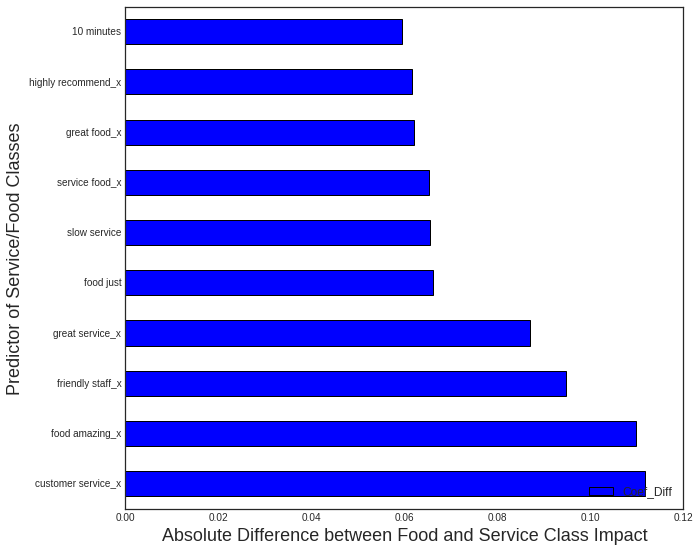

In [100]:
fig = plt.figure(figsize=(10,9))
ax = fig.gca()
variables[0:10].plot.barh(x='Variable',y='Coef_Diff',ax=ax)
plt.ylabel('Predictor of Service/Food Classes', fontsize=18)
plt.xlabel('Absolute Difference between Food and Service Class Impact', fontsize=18)
plt.legend(loc="lower right")
plt.show()

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


In [29]:
#Had to reread in the reviews dataset since I removed some columns before
reviews = pd.read_csv('/home/llevin/Desktop/DSI-SF-2-llevin16/Projects/Project 5/Data/yelp_arizona_data/reviews_small_nlp_parsed.csv')

DATA CLEANING PHASE

In [30]:
#Group reviews by user and remove unnecessary columns
reviews['Reviews']=1
cols = [col for col in reviews.columns if col not in ['business_id','review_id','date']]
reviews = reviews[cols]
grouped_r = reviews.groupby('user_id').sum().reset_index()

In [31]:
#Create target variable from elite years. If they were elite at all vs. if they were never elite.
users['target'] = users['elite'].map(lambda x: False if x == '[]' else True)
users['target'].value_counts()

False    127583
True      16623
Name: target, dtype: int64

In [32]:
#Fill in nulls with 0
users.fillna(value=0.,inplace=True)

In [33]:
#Merge reviews and users 
users_vf = users.merge(grouped_r,how='inner',left_on='user_id',right_on='user_id')

In [34]:
users_vf['target'].value_counts()

False    127583
True      16623
Name: target, dtype: int64

REGRESSION PHASE

In [35]:
#Set up target and predictors and normalize
y = users_vf['target']
X = users_vf[[col for col in users_vf.columns if col not in ['elite','name','user_id','target','yelping_since']]]

scale = StandardScaler()
Xn = scale.fit_transform(X)

print Xn.shape,y.shape

(144206, 122) (144206,)


In [36]:
# Setup our GridSearch Parmaters
search_parameters = {
    'penalty':  ['l1','l2'],
    'solver':  ['liblinear']
}

# Intialize a blank model object
log = LogisticRegression()

# Initialize gridsearch
grid = GridSearchCV(log, search_parameters, cv=5, verbose=1)
log_best = grid.fit(Xn,y).best_estimator_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  8.2min finished


In [37]:
#Manual cross validation and results printing
cv_indices = StratifiedKFold(y, n_folds=5)

log_scores = []

for train,test in cv_indices:
    x_train = Xn[train,:]
    x_test = Xn[test,:]
    y_train = y[train]
    y_test = y[test]
    
    log_best.fit(x_train,y_train)
    
    log_scores.append(log_best.score(x_test,y_test))

print log_scores
print 'Log Score: ',np.mean(log_scores)
print 'Baseline: ',np.mean(y)

[0.94899798904375565, 0.94774980930587338, 0.94774980930587338, 0.94580443828016647, 0.94601248266296811]
Log Score:  0.94726290572
Baseline:  0.115272596147


In [38]:
#Look at most important predictors
importance = pd.DataFrame({'Coef':log_best.coef_[0],'Abs_Coef':np.abs(log_best.coef_[0]),'Variable':X.columns})
importance.sort_values('Abs_Coef',ascending=False,inplace=True)
importance[0:10]

,Abs_Coef,Coef,Variable
3,5.122098,5.122098,compliments.writer
8,4.587370,-4.587370,compliments.profile
10,3.788009,3.788009,compliments.more
16,3.308001,3.308001,votes.useful_x
7,2.039703,2.039703,compliments.cool
1,1.812202,1.812202,review_count
11,1.753420,-1.753420,votes.cool_x
13,1.709512,-1.709512,votes.funny_x
14,1.486408,-1.486408,compliments.photos
121,1.272227,-1.272227,Reviews


In [39]:
#Rerun regressions without all count metrics
y = users_vf['target']
X = users_vf[[col for col in users_vf.columns if col not in ['elite','name','user_id','target','yelping_since',
                                                      'compliments.plain','review_count','compliments.cute',
                                                       'compliments.writer','compliments.note','compliments.hot',
                                                       'compliments.cool','compliments.profile','compliments.more',
                                                       'votes.cool_x','compliments.list','votes.funny_x',
                                                       'compliments.photos','compliments.funny','votes.useful_x',
                                                       'votes.cool_y','votes.funny_y','votes.useful_y']]]

scale = StandardScaler()
Xn = scale.fit_transform(X)

print Xn.shape,y.shape

(144206, 104) (144206,)


In [40]:
# Setup our GridSearch Parmaters
search_parameters = {
    'penalty':  ['l1','l2'],
    'solver':  ['liblinear']
}

# Intialize a blank model object
log = LogisticRegression()

# Initialize gridsearch
grid = GridSearchCV(log, search_parameters, cv=5, verbose=1)
log_best = grid.fit(Xn,y).best_estimator_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished


In [42]:
cv_indices = StratifiedKFold(y, n_folds=5)

log_scores = []

for train,test in cv_indices:
    x_train = Xn[train,:]
    x_test = Xn[test,:]
    y_train = y[train]
    y_test = y[test]
    
    log_best.fit(x_train,y_train)
    
    log_scores.append(log_best.score(x_test,y_test))

print log_scores
print 'Log Score: ',np.mean(log_scores)
print 'Baseline: ',np.mean(y)

[0.93845780459052774, 0.93703626655571737, 0.93779904306220097, 0.93547156726768377, 0.93370319001386959]
Log Score:  0.936493574298
Baseline:  0.115272596147


In [43]:
importance = pd.DataFrame({'Coef':log_best.coef_[0],'Abs_Coef':np.abs(log_best.coef_[0]),'Variable':X.columns})
importance.sort_values('Abs_Coef',ascending=False,inplace=True)
importance[0:10]

,Abs_Coef,Coef,Variable
0,6.390329,6.390329,fans
2,0.636273,0.636273,stars
103,0.522112,-0.522112,Reviews
98,0.087437,0.087437,time vegas
78,0.087126,0.087126,pretty good
47,0.085219,-0.085219,great food
13,0.084658,-0.084658,customer service
39,0.069644,-0.069644,friendly staff
80,0.069526,0.069526,really enjoyed
66,0.057895,-0.057895,love place


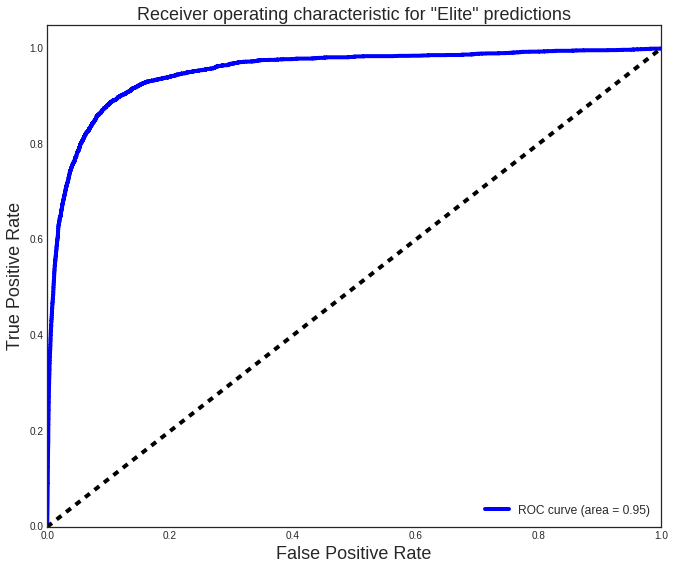

In [44]:
log_probs = log_best.predict_proba(x_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

FPR[1], TPR[1], _ = roc_curve(y_test, log_probs[:, 1])
ROC_AUC[1] = auc(FPR[1], TPR[1])

# [insert explanation of this section -- what is being plotted?  Which elements are data driven?  Which elements are purely visual?]
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for "Elite" predictions', fontsize=18)
plt.legend(loc="lower right")
plt.show()

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

I would have liked to do the challenge questions but it seems my computer is having slowdown issues whenever it tries to run regressions. I would have chosen businesses which get 'high' average ratings vs. 'low' average ratings. 'High' would be defined as an average rating of 4-5 else 'Low'. If I have time I will just do a straight logistic regression to save time. 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?